In [32]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import sys
sys.path.insert(1,'../')
from oml.angles import euler2quaternion
from oml.alignment import loss_alignment

In [87]:
def create_unique_angle(point, ret_full=False):
    """Constructs the equivalent 6d vector with all positive components
    such that their sum is minimum"""
    add_pi = lambda x: x + np.pi
    opp = lambda x: -x
    opp_pi = lambda x: np.pi - x
    idd = lambda x: x
    LIST_FUN = [idd, opp, add_pi, opp_pi]
    LIST_EQUIV = [
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 2, 3, 2],
        [0, 0, 2, 0, 3, 2],
        [0, 0, 2, 2, 0, 0],
        [0, 2, 1, 1, 2, 0],
        [0, 2, 1, 3, 1, 2],
        [0, 2, 3, 1, 1, 2],
        [0, 2, 3, 3, 2, 0],
        [2, 1, 1, 1, 1, 2],
        [2, 1, 1, 3, 2, 0],
        [2, 1, 3, 1, 2, 0],
        [2, 1, 3, 3, 1, 2],
        [2, 3, 0, 0, 3, 2],
        [2, 3, 0, 2, 0, 0],
        [2, 3, 2, 0, 0, 0],
        [2, 3, 2, 2, 3, 2]
    ]
    _point = [x % (2 * np.pi) for x in point]
    best_sum = np.inf
    best_point = None
    best_eq = None
    diff_1 = np.array(_point) - np.array(point)
    diff_2 = np.zeros(6)
    for eq in LIST_EQUIV:
        x = np.zeros_like(point)
        _diff_2 = np.zeros(6)
        for i in range(6):
            x[i] = LIST_FUN[eq[i]](point[i])
            if x[i] < 0:
                x[i] += 2 * np.pi
                _diff_2[i] += 2 * np.pi
            elif x[i] > (2 * np.pi):
                x[i] -= 2 * np.pi
                _diff_2[i] -= 2 * np.pi
        if sum(x) == best_sum:
            # Ties are solved by smaller first components
            for i in range(6):
                if x[i] == best_point[i]:
                    continue
                elif x[i] < best_point[i]:
                    best_point = x
                    best_eq = eq
                    diff_2 = _diff_2.copy()
                    break
                else:
                    break
        elif sum(x) < best_sum:
            best_point = x
            best_sum = sum(x)
            best_eq = eq
            diff_2 = _diff_2.copy()
    if ret_full:
        best_eq = [LIST_FUN[best_eq[i]] for i in range(6)]
        return best_point, best_eq, diff_1, diff_2
    return best_point

def show_projection_crit_points(proj):
    _y = y_proj[proj]
    colors = ['navy', 'darkorange']
    for color, i, target_name in zip(colors, [True, False], ['good', 'bad']):
        _yi = _y[df.good_conv == i]
        plt.scatter(_yi[:,0], _yi[:,1], alpha=.3, color=color, label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(f'{proj} of critical points')
    plt.show()

# Projected critical points

In [17]:
df = pd.read_csv("../results/alignment/loss.csv")
df['seed'] = df.seed.astype(int)
df['good_conv'] = (df['final_loss'] < 0.1)

In [18]:
n_runs = 100
trajectories = {}
critical_points = np.zeros([n_runs, 6])
for i in range(n_runs):
    trajectories[i] = np.load(f'../results/alignment/trajectories/{i}.npy')
    critical_points[i, :] = trajectories[i][-1, :]

In [19]:
y = list()
for x in critical_points:
    y.append(create_unique_angle(x))
y = np.array(y)

In [20]:
pca = PCA()
pca.fit(y)
print(pca.explained_variance_ratio_)

[0.66253589 0.22295879 0.05092455 0.04399491 0.01360243 0.00598343]


In [21]:
y_proj = {}
model = PCA(n_components=2)
y_proj['PCA'] = model.fit_transform(y)
model = TSNE(n_components=2)
y_proj['TSNE'] = model.fit_transform(y)
model = MDS(n_components=2)
y_proj['MDS'] = model.fit_transform(y)

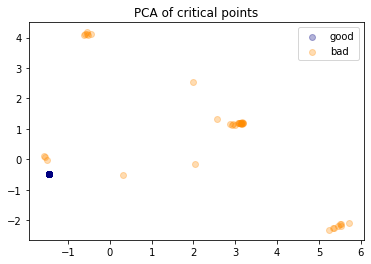

In [22]:
show_projection_crit_points('PCA')

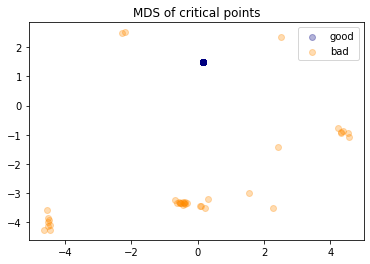

In [23]:
show_projection_crit_points('MDS')

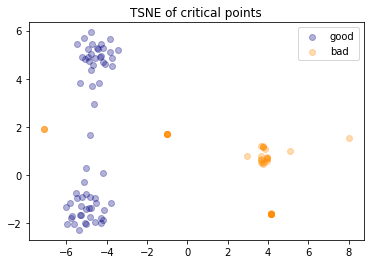

In [24]:
show_projection_crit_points('TSNE')

# Projected trajectories

In [25]:
angles_true = np.load("../data/angles_true.npy")
q_true = euler2quaternion(angles_true)
q_pred = np.load("../data/predicted_quaternions2.npy")

In [112]:
good_point = y[df.good_conv == True].mean(0)
good_point = np.expand_dims(good_point, 0)
RES = (50, 50)

In [153]:
def plot_trajectory(t, w_good=10):
    _, fun, diff1, diff2 = create_unique_angle(t[-1], ret_full=True)
    t = np.array([[fun[i](tt[i] + diff1[i]) + diff2[i] for i in range(6)] for tt in t])
    t = np.concatenate([t] + [good_point] * w_good)

    model = PCA(n_components=2)
    t = model.fit_transform(t)
    ls_dim = lambda dim: np.linspace(t[:,dim].min(), t[:,dim].max(), RES[dim])
    X, Y = np.meshgrid(ls_dim(0), ls_dim(1))
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            angle = model.inverse_transform((X[i,j], Y[i,j]))
            angle = [tf.Variable(angle)]
            Z[i,j] = loss_alignment([1., 1., 1., 1.], angle, q_pred, q_true)

    fig,ax=plt.subplots(1,1, figsize=(15,15))
    cp = ax.contourf(X, Y, Z, levels=40)
    ax.plot(t[:-w_good,0], t[:-w_good,1], color='orange')
    ax.scatter(t[-w_good-1,0], t[-w_good-1,1], color='red', zorder=3)
    fig.colorbar(cp) # Add a colorbar to a plot
    ax.set_title('Contours Plot')
    return fig

for i, tt in trajectories.items():
    plot_trajectory(tt).savefig(f'../results/alignment/trajectories_plots/{i}.png')
    plt.close()